# OUTLINE:
GETTING DATA  
EDA (TREND, SEASONALITY) -> the Dickey–Fuller test-> STATIONARITY  
DATA ENGINEERING, PREPROCESING  
MODELING (ARIMA)  
FORECAST, ERRORS

In [2]:
%matplotlib inline

In [3]:
# import libraries
# general:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# models:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR

# metrics:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

TIME SERIES:

univariate TS is a sequence of measurments of the SAME variable collected over time

data in TS not necessarly independent and not necessarly identically distributed

the ordering matters

***
***
# PART_1
***
***

GETTING DATA FROM IMF

https://www.imf.org/external/datamapper/NGDP_RPCH@WEO/USA/WEOWORLD

IMF DATA MAPPER:  
https://www.imf.org/external/datamapper/datasets

DATASETS:  
https://www.imf.org/external/pubs/ft/weo/2019/01/weodata/index.aspx


In [4]:
# import data about world GDP and GDP GROWTH
data= pd.read_csv('data/world_data.xls', sep= '\t', index_col= 0, header= None)

In [5]:
# transpose and delete columns
data = data.T.iloc[4:-1, 0:3]

# rename columns
data.columns= ['YEAR', 'WORLD_GROWTH', 'WORLD_GDP']

# chage data type from string --> float
data.WORLD_GDP= data.WORLD_GDP.str.replace(',', '')
data= data.astype('float')

# change data type to datetime and set new index
data['YEAR']= pd.to_datetime(data.YEAR, format= '%Y')
data.set_index(data['YEAR'], drop= True, inplace= True)
data= data.drop(['YEAR'], axis= 1)

In [6]:
# split data on actual and predicted
data_train= data.iloc[:-6, :]
data_test= data.iloc[-6:, :]

In [7]:
# create separate series
world_growth_train= data_train.WORLD_GROWTH
world_gdp_train= data_train.WORLD_GDP

In [8]:
# save every series as a pickle fle
with open ('world_growth_train.pickle', 'wb') as file:
    pickle.dump(world_growth_train, file, pickle.HIGHEST_PROTOCOL)
    
with open ('world_gdp_train.pickle', 'wb') as file:
    pickle.dump(world_gdp_train, file, pickle.HIGHEST_PROTOCOL)

In [9]:
# def get_clean (file_name):
#     data= pd.read_csv(file_name, sep= '\t', index_col= 0, header= None)

REPEAT FOR US

In [10]:
# import data about world GDP and GDP GROWTH
data= pd.read_csv('data/us_data.xls', sep= '\t', index_col= 0, header= None)

In [11]:
# transpose and delete columns
data = data.T.iloc[4:-1, 0:3]

# rename columns
data.columns= ['YEAR', 'US_GROWTH', 'US_GDP']

# chage data type from string --> float
data.US_GDP= data.US_GDP.str.replace(',', '')
data= data.astype('float')

# change data type to datetime and set new index
data['YEAR']= pd.to_datetime(data.YEAR, format= '%Y')
data.set_index(data['YEAR'], drop= True, inplace= True)
data= data.drop(['YEAR'], axis= 1)

In [12]:
# split data on actual and predicted
data_train= data.iloc[:-6, :]
data_test= data.iloc[-6:, :]

# create separate series
us_growth_train= data_train.US_GROWTH
us_gdp_train= data_train.US_GDP

# save every series as a pickle fle
with open ('us_growth_train.pickle', 'wb') as file:
    pickle.dump(us_growth_train, file, pickle.HIGHEST_PROTOCOL)
    
with open ('us_gdp_train.pickle', 'wb') as file:
    pickle.dump(us_gdp_train, file, pickle.HIGHEST_PROTOCOL)

OVERALL IMAGES:
GROWTH
GDP

In [13]:
# create a graph using plotly library

layout= go.Layout(yaxis={"title": "annual growth, %"}, xaxis= {'title': 'year'})


fig= go.Figure(layout=layout)

fig.add_trace(go.Scatter(
    x= world_growth_train.index,
    y= world_growth_train,
    name= 'world_growth',
    line_color= 'deepskyblue',
    opacity= .8)
             )
fig.add_trace(go.Scatter(
    x=us_growth_train.index,
    y= us_growth_train, 
    name= 'us_growth',
    line_color= 'red',
    opacity= .8)
             )
layout= go.Layout(showlegend= True)
# Set options common to all traces with fig.update_traces
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=5)

fig.update_layout(title_text= 'WORLD vs US GROWTH', xaxis_rangeslider_visible=True)
fig.show()

In [14]:
# create a graph for GDP using plotly library 
layout= go.Layout(yaxis={"title": "billions, US dollars"}, xaxis= {'title': 'year'})

fig= go.Figure(layout= layout)

fig.add_trace(go.Scatter(
    x= world_gdp_train.index,
    y= world_gdp_train,
    name= 'world_gdp',
    line_color= 'deepskyblue',
    opacity= .8)
             )
fig.add_trace(go.Scatter(
    x=us_gdp_train.index,
    y= us_gdp_train, 
    name= 'us_gdp',
    line_color= 'red',
    opacity= .8)
             )
# Set options common to all traces with fig.update_traces
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=5)

fig.update_layout(title_text= 'WORLD vs US GDP', xaxis_rangeslider_visible=True)

fig.show()

In [15]:
# WORLD ONLY
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x= world_growth_train.index,
               y= world_growth_train,
               name="yaxis data"), secondary_y=False,
)

fig.add_trace(
    go.Scatter( x= world_gdp_train.index,
               y= world_gdp_train,
               name="yaxis2 data"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Double Y Axis Example", xaxis_rangeslider_visible=True
)

fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=5)

# Set x-axis title
fig.update_xaxes(title_text="year")

# Set y-axes titles
fig.update_yaxes(title_text="growth, %", secondary_y=False)
fig.update_yaxes(title_text="billions, US dollars", secondary_y=True)

fig.show()

***
***
PART_2
***
***

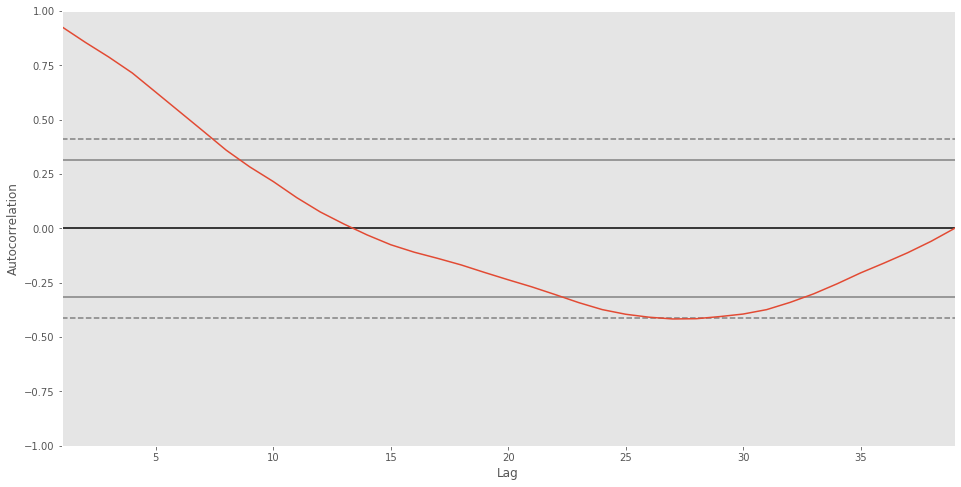

In [16]:
plt.figure(figsize=(16,8))
pd.plotting.autocorrelation_plot(world_gdp_train);

In [17]:
#rolling statistics
# pandas rolling (window=, center= ).mean()
# pandas rolling (window=, center= ).std()

In [18]:
#the dickey-fuller test
# dftest= adfuller()

***
***
PART_3
***
***

In [19]:
# log_transformation
# subtract rolling mean
# differecing
# pandas diff(periods= 1)
# decomposition
# decompostion= seasonal_decompose()
# trend= decomposition.trend
# seasonal= decomposition.seasonal
# residual= decomposition.resid

***
***
PART_4
***
***

PART_4.1 SAMPLE AUTOCORRELATION FUNCTION (ACF)

A sample autocorrelation function (ACF)for a series gives correlations between the series $x_t$ and lagged values of the series for lags 1, 2, 3, and so on. The lagged values can be written as $x_{t-1}, x_{t-2}, x_{t-3}$, and so on. The ACF gives correlations between $x_t$ and $x_{t-1}$, $x_t$ and $x_{t-2}$, and so on.

The ACF can be used to identify possible structure of time series data.

In [20]:
#?np.arange

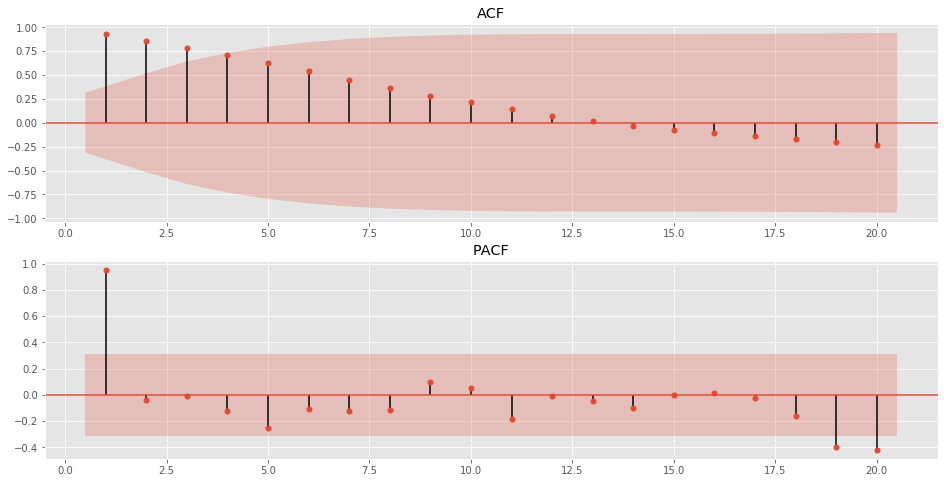

In [21]:
fig = plt.figure(figsize=(16,8))

#plot the ACF

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(world_gdp_train, lags=20, title='ACF', zero= False, ax=ax1)

#plot the PACF

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(world_gdp_train, lags=20, title= 'PACF', zero= False, ax=ax2)

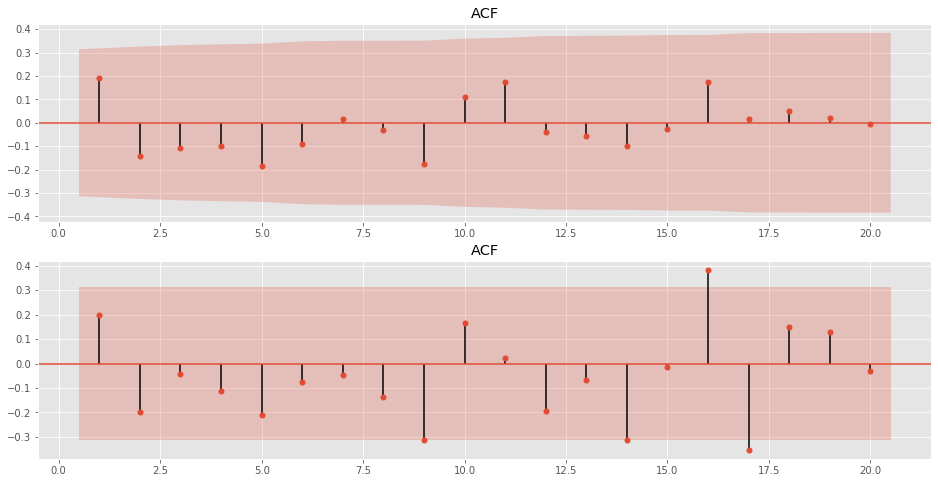

In [22]:
fig = plt.figure(figsize=(16,8))

#plot the ACF

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(world_growth_train, lags=20, title= 'ACF', zero= False, ax=ax1)

#plot the PACF

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(world_growth_train, lags=20, title= 'ACF', zero= False, ax=ax2)

In [23]:
def explore_first_difference(Series, n):
    '''
    Input: pandas.Series, number of differnces
    Output: 
    '''
    diff= Series.diff(n)
    
    fig = plt.figure(figsize=(16,8))
    
    # plot difference
    ax1= fig.add_subplot(211)
    plt.plot(diff, ax= ax1)
    
    #plot the ACF
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_acf(diff, lags=18, ax=ax2)
    
    #plot the PACF
    ax3 = fig.add_subplot(213)
    fig = sm.graphics.tsa.plot_pacf(diff, lags=18, ax=ax3)

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



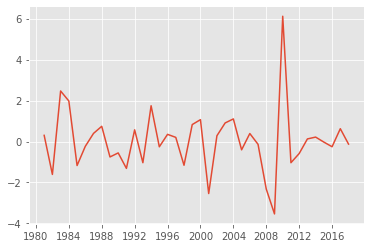

In [24]:
first_diff= world_growth_train.diff(1)
plt.plot(first_diff)

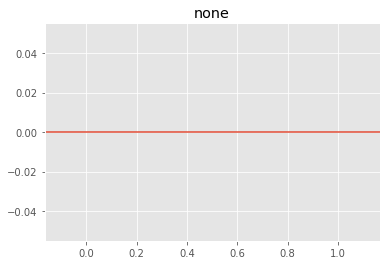

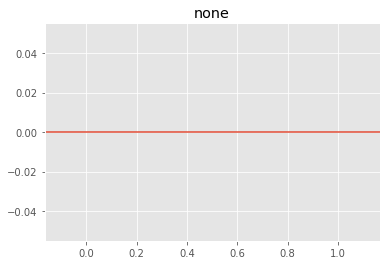

In [25]:
sm.graphics.tsa.plot_acf(first_diff, title='none')

In [26]:
#explore_first_difference(world_gdp_train, 1)

One of the simplest ARIMA type models is a model in which we use a linear model to predict the value at the present time using the value at the previous time. This is called __an AR(1) model__, standing for autoregressive model of order 1. The order of the model indicates how many previous times we use to predict the present time.

In [27]:
# create a function which outputs a dataframe with lags
def shift_n (Series, n):
    '''
    Input: pandas.Series, number of lags
    Ouput: dataFrame
    '''
    data= pd.DataFrame(Series)
    data['lag']= data.shift(n)
    return data

In [42]:
data= shift_n(world_gdp_train, 1)

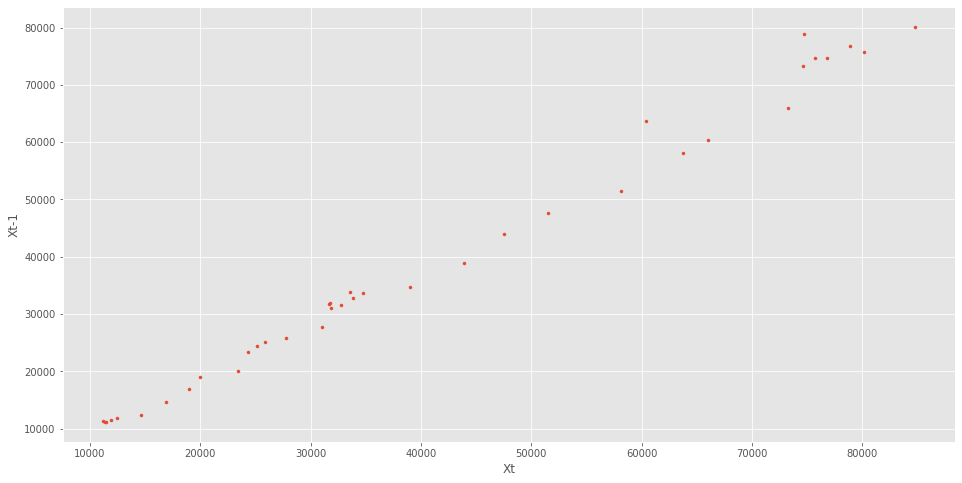

In [43]:
plt.figure(figsize= (16, 8))
plt.scatter(data.WORLD_GDP, data.lag, marker= '.')
plt.xlabel('Xt')
plt.ylabel('Xt-1')
plt.show()

the same with plotly

In [45]:
dat= go.Scatter(x= data.WORLD_GDP, y= data.lag,
                 mode= 'markers', marker=dict(size=list(range(10, 100, 10))*1000, color=[0, 1, 2, 3])
                 )

fig= go.Figure(data= dat)

fig.show()

the AR(1) model is written:
$x_t = \delta + \phi_1x_t-1 + \epsilon_t$

Assumptions:
- $\epsilon_t \stackrel{\text{iid}}{\sim} N(0, \sigma^2_t)$, meaning that the errors are independently distributed with a normal distribution that has mean 0 and constant variance;
- Properties of the errors $\epsilon_t$ are independent of $x$.

In [46]:
from math import ceil

In [47]:
# create train/test split
train= data.WORLD_GDP.iloc[: ceil(.8*len(data))]
test= data.WORLD_GDP.iloc[len(train) : ]

In [48]:
# train a model
model= AR(train)
model_fitted= model.fit()

print(f'a lag value chose is {model_fitted.k_ar}')
print(f'the coefs are:\n {model_fitted.params}' )

a lag value chose is 9
the coefs are:
 const          -198.082576
L1.WORLD_GDP      1.004984
L2.WORLD_GDP     -0.234515
L3.WORLD_GDP      0.554258
L4.WORLD_GDP      0.117126
L5.WORLD_GDP     -0.628361
L6.WORLD_GDP     -0.482215
L7.WORLD_GDP      0.783994
L8.WORLD_GDP     -0.106731
L9.WORLD_GDP      0.104666
dtype: float64


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



<Figure size 1152x576 with 0 Axes>

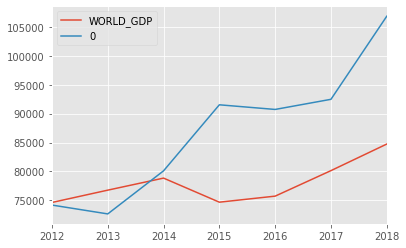

In [49]:
# make predictions 
predictions = model_fitted.predict(
    start=len(train), 
    end=len(train) + len(test)-1, 
    dynamic=False)

# create a comparison dataframe
compare_df = pd.concat(
    [test,
    predictions], axis=1)

#plot the two values
plt.figure(figsize= (16, 8))
compare_df.plot()
plt.show()

In [50]:
print(f'r2 score: {r2_score(test, predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions))}')

r2 score: -13.661876624197705
RMSE: 12914.779663027884


GROWTH

a lag value chose is 9
the coefs are:
 const              9.610817
L1.WORLD_GROWTH   -0.042274
L2.WORLD_GROWTH   -0.245613
L3.WORLD_GROWTH   -0.361858
L4.WORLD_GROWTH   -0.463648
L5.WORLD_GROWTH   -0.495068
L6.WORLD_GROWTH    0.131543
L7.WORLD_GROWTH   -0.278283
L8.WORLD_GROWTH    0.159511
L9.WORLD_GROWTH   -0.646063
dtype: float64


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



<Figure size 1152x576 with 0 Axes>

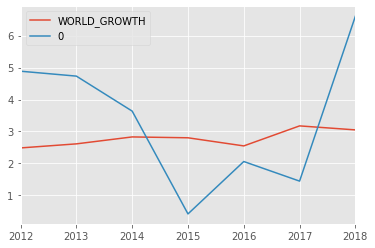

r2 score: -80.13538470438732
RMSE: 2.151425410397956


In [51]:
# create train/test split
number= len(world_growth_train)
train= world_growth_train.iloc[: ceil(.8*number)]
test= world_growth_train.iloc[len(train):]

# train a model
model= AR(train)
model_fitted= model.fit()

print(f'a lag value chose is {model_fitted.k_ar}')
print(f'the coefs are:\n {model_fitted.params}' )

# make predictions 
predictions = model_fitted.predict(
    start=len(train), 
    end=len(train) + len(test)-1, 
    dynamic=False)

# create a comparison dataframe
compare_df = pd.concat(
    [test,
    predictions], axis=1)

#plot the two values
plt.figure(figsize= (16, 8))
compare_df.plot()
plt.show()

print(f'r2 score: {r2_score(test, predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions))}')

# RESIDUAL ANALYSIS#

In [52]:
import itertools
from matplotlib.pylab import rcParams

In [53]:
mod= ARIMA(data_train.WORLD_GROWTH, (1, 1, 0))
res= mod.fit()

AttributeError: 'DataFrame' object has no attribute 'WORLD_GROWTH'

In [ ]:
res.summary()

In [ ]:
data_train['predict'] = res.predict(start= 32, end= 39, dynamic= False)  
data_train[['WORLD_GROWTH', 'predict']].plot(figsize=(16, 12)) 

In [54]:
#world_growth_train

In [55]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [56]:
# Run a grid with pdq parameters calculated above and get the best AIC value

ans = []
for comb in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(us_gdp_train,
                                            order=comb,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, output.aic])
            print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
        except:
            continue

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (0, 0, 0) : AIC Calculated =821.5562544881302
ARIMA (0, 0, 1) : AIC Calculated =875.8357170376365
ARIMA (0, 1, 0) : AIC Calculated =569.9437258822463
ARIMA (0, 1, 1) : AIC Calculated =528.4209300773188
ARIMA (1, 0, 0) : AIC Calculated =518.721728952575
ARIMA (1, 0, 1) : AIC Calculated =497.2968052520717
ARIMA (1, 1, 0) : AIC Calculated =505.3900634769632
ARIMA (1, 1, 1) : AIC Calculated =490.089289342641


In [72]:
# Find the parameters with minimal AIC value.

ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq    (1, 1, 1)
aic      490.089
Name: 7, dtype: object

In [94]:
# plug the optimal parameter values into a new SARIMAX model.
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(us_gdp_train,
                                order=(1, 1, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit the model and print results

output = ARIMA_MODEL.fit()

print(output.summary())


                           Statespace Model Results                           
Dep. Variable:                 US_GDP   No. Observations:                   39
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -242.045
Date:                Wed, 24 Jul 2019   AIC                            490.089
Time:                        12:27:12   BIC                            494.840
Sample:                    01-01-1980   HQIC                           491.747
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0253      0.007    148.050      0.000       1.012       1.039
ma.L1         -1.0000      0.151     -6.626      0.000      -1.296      -0.704
sigma2      3.739e+04   4.04e-06   9.26e+09      0.0

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



490.089289342641

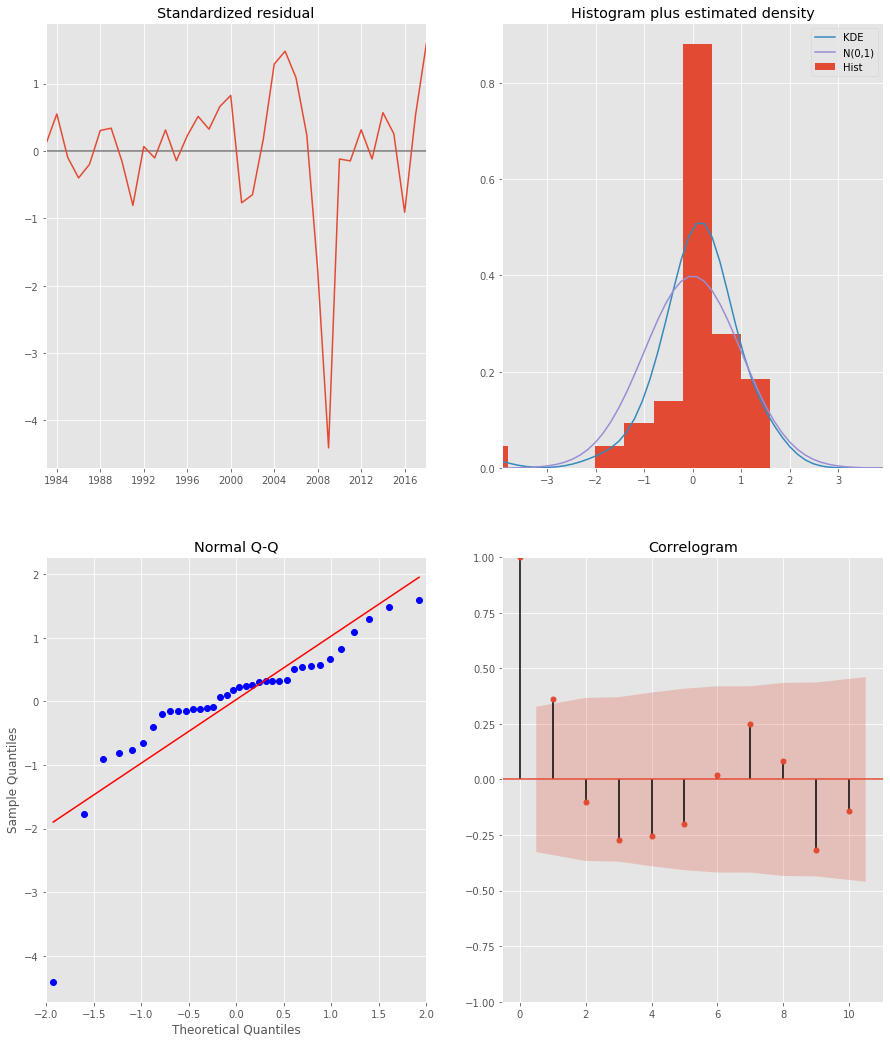

In [104]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [110]:
# Get predictions starting from 01-01-2011 and calculate confidence intervals.

pred = output.get_prediction(start='2011-01-01', dynamic=False)
pred_conf = pred.conf_int()

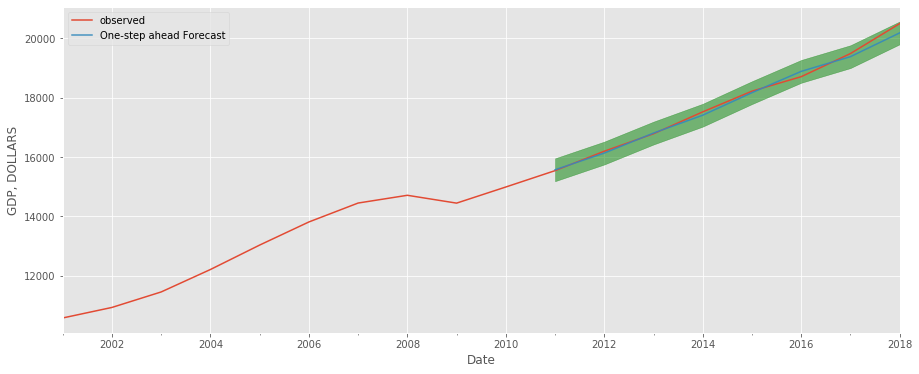

In [111]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = us_gdp_train['2001':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range bfor confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('GDP, DOLLARS')
plt.legend()

plt.show()

In [112]:
# Get the Real and predicted values
GDP_forecasted = pred.predicted_mean
GDP_truth= us_gdp_train['2011-01-01':]

# Compute the mean square error
mse = ((GDP_forecasted - GDP_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 20064.54


# DYNAMIC

In [81]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('2011-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

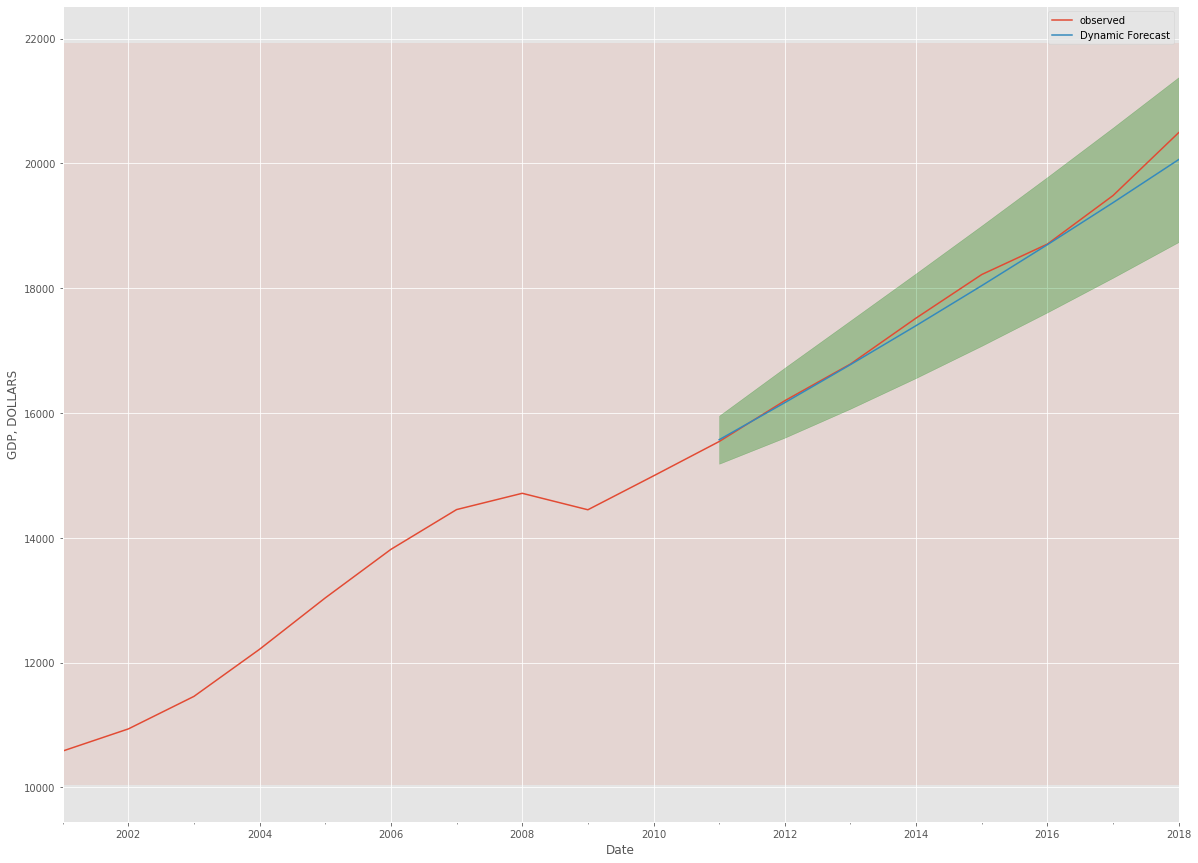

In [82]:
# Plot the dynamic forecast with confidence intervals.

ax = us_gdp_train['2001':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2001-01-01'), GDP_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('GDP, DOLLARS')

plt.legend()
plt.show()

In [83]:
# Extract the predicted and true values of our time series
GDP_forecasted = pred_dynamic.predicted_mean
GDP_truth = us_gdp_train['2011-01-01':]

# Compute the mean square error
mse = ((GDP_forecasted - GDP_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 31024.44


In [84]:
# Get forecast 10 steps ahead in future
prediction = output.get_forecast(steps=10)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

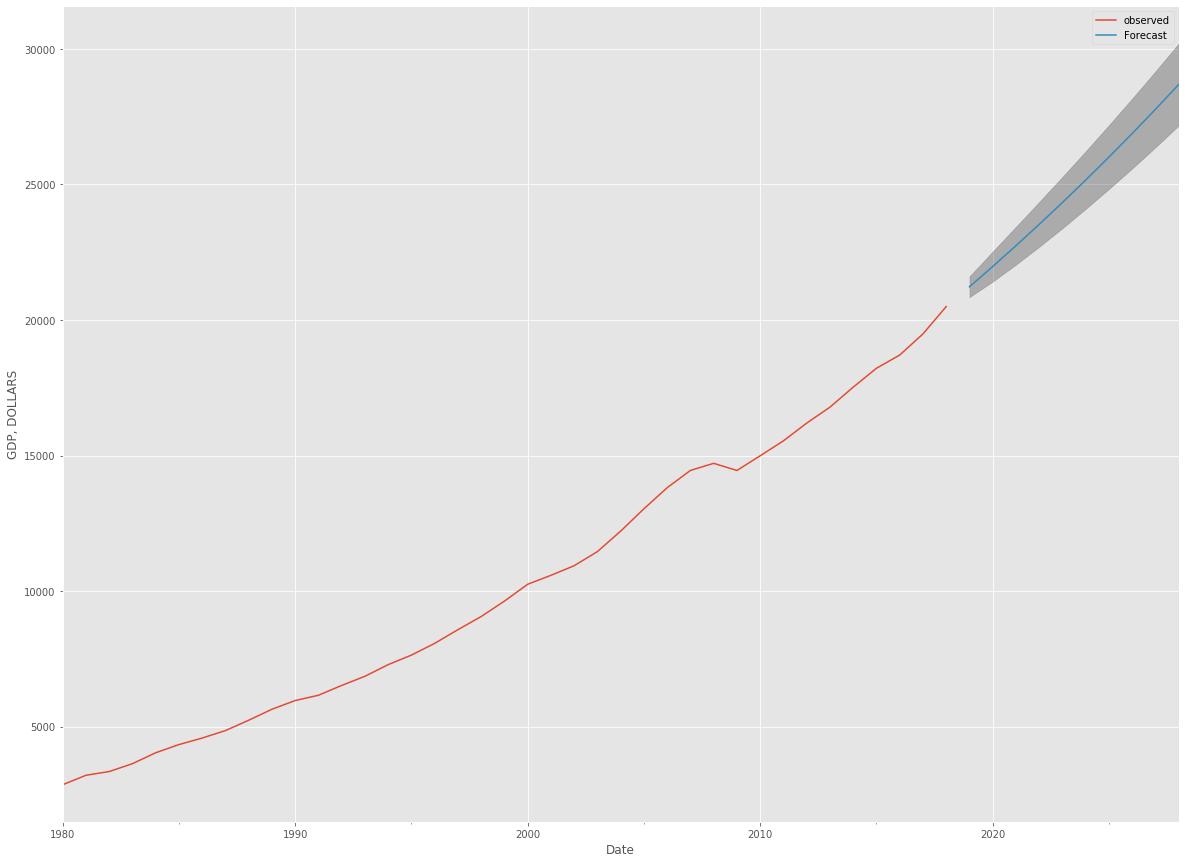

In [85]:
# Plot future predictions with confidence intervals

ax = us_gdp_train.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('GDP, DOLLARS')

plt.legend()
plt.show()

In [117]:
def analyse_series (Series, p, d, q, year):
    '''
    Input:
    Output:
    '''
    # plug the optimal parameter values into a new SARIMAX model.
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(Series,
                                order=(p, d, q),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    # Fit the model and print results

    output = ARIMA_MODEL.fit()

    print(output.summary())
    
    # Use plot_diagnostics with results calculated above.
    output.plot_diagnostics(figsize=(18, 18))
    plt.show()
    
    # Get predictions starting from 01-01-year and calculate confidence intervals.

    pred = output.get_prediction(start='{}-01-01'.format(year), dynamic=False)
    pred_conf = pred.conf_int()
    
    # Plot real vs predicted values along with confidence interval

    rcParams['figure.figsize'] = 15, 6

    #Plot observed values
    ax = Series['{}'.format(year):].plot(label='observed')

    #Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='one-step ahead Forecast', alpha=.5)

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='y', alpha=.5)

    #Set axes labels
    ax.set_xlabel('date')
    ax.set_ylabel('prediction')
    plt.legend()

    plt.show()
    
    # Extract the predicted and true values of our time series
    forecast= pred.predicted_mean
    true= Series['{}-01-01'.format(year):]

    # Compute the mean square error
    mse = ((forecast - true) ** 2).mean()
    print('The Mean Squared Error is: {}'.format(round(mse, 2)))

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



                           Statespace Model Results                           
Dep. Variable:              US_GROWTH   No. Observations:                   39
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -77.637
Date:                Wed, 24 Jul 2019   AIC                            159.274
Time:                        12:45:39   BIC                            162.496
Sample:                    01-01-1980   HQIC                           160.410
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2948      0.095     -3.101      0.002      -0.481      -0.108
sigma2         3.8912      0.796      4.888      0.000       2.331       5.451
Ljung-Box (Q):                         nan   Jarque-

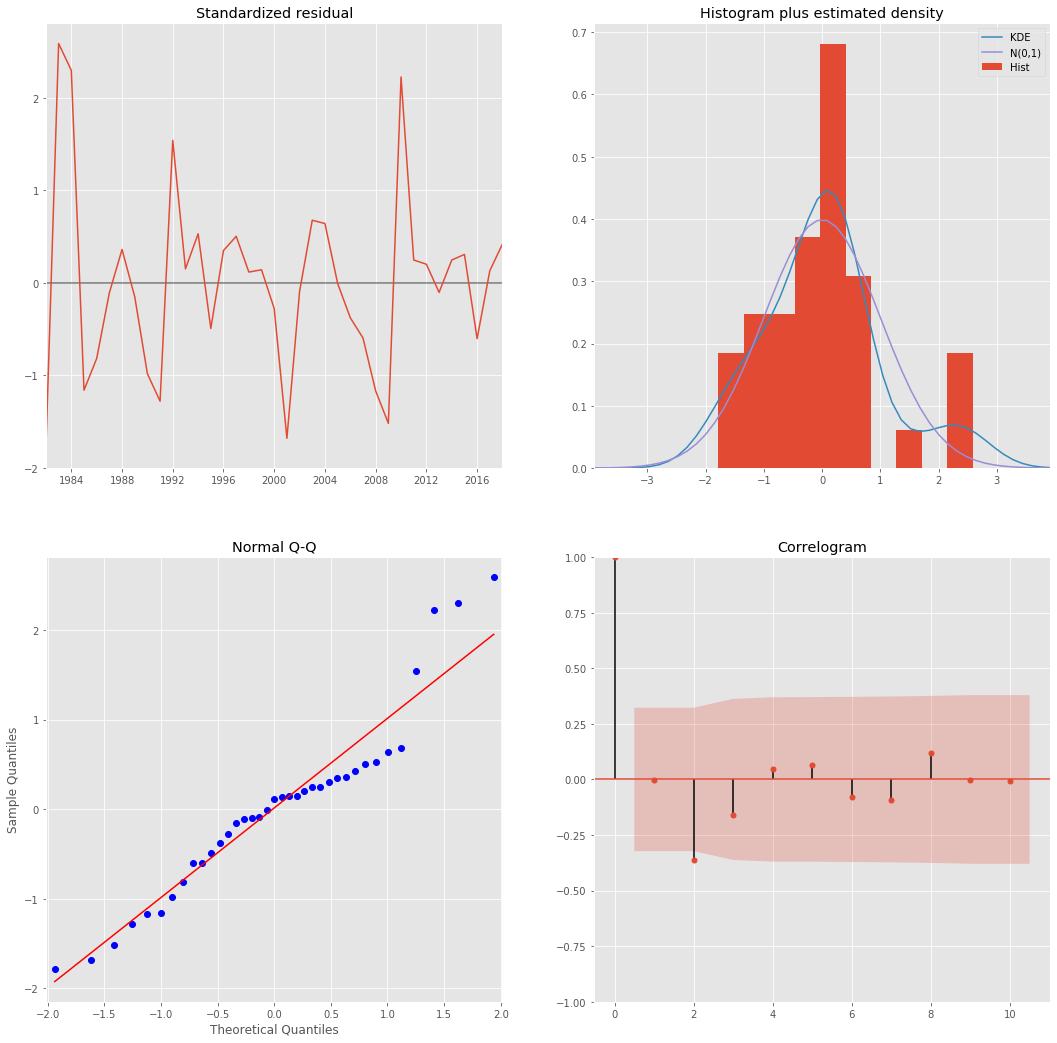

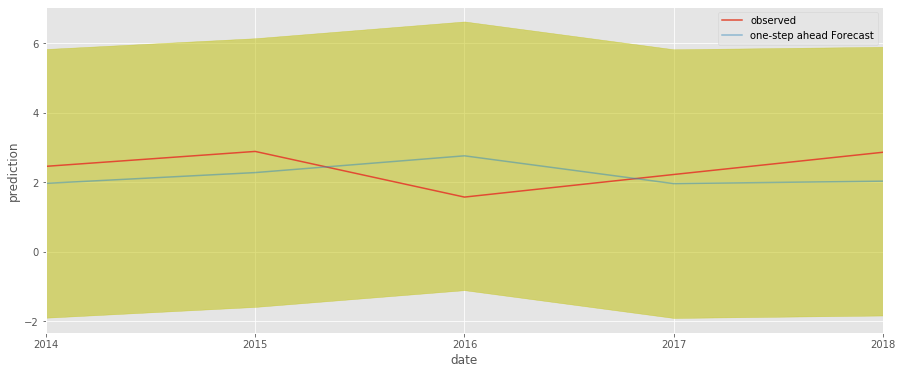

The Mean Squared Error is: 0.56


In [118]:
analyse_series(us_growth_train, 1, 1, 0, 2014)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



                           Statespace Model Results                           
Dep. Variable:              WORLD_GDP   No. Observations:                   39
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -344.063
Date:                Wed, 24 Jul 2019   AIC                            692.126
Time:                        12:46:10   BIC                            695.348
Sample:                    01-01-1980   HQIC                           693.262
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5469      0.129      4.253      0.000       0.295       0.799
sigma2      6.991e+06   1.57e+06      4.461      0.000    3.92e+06    1.01e+07
Ljung-Box (Q):                         nan   Jarque-

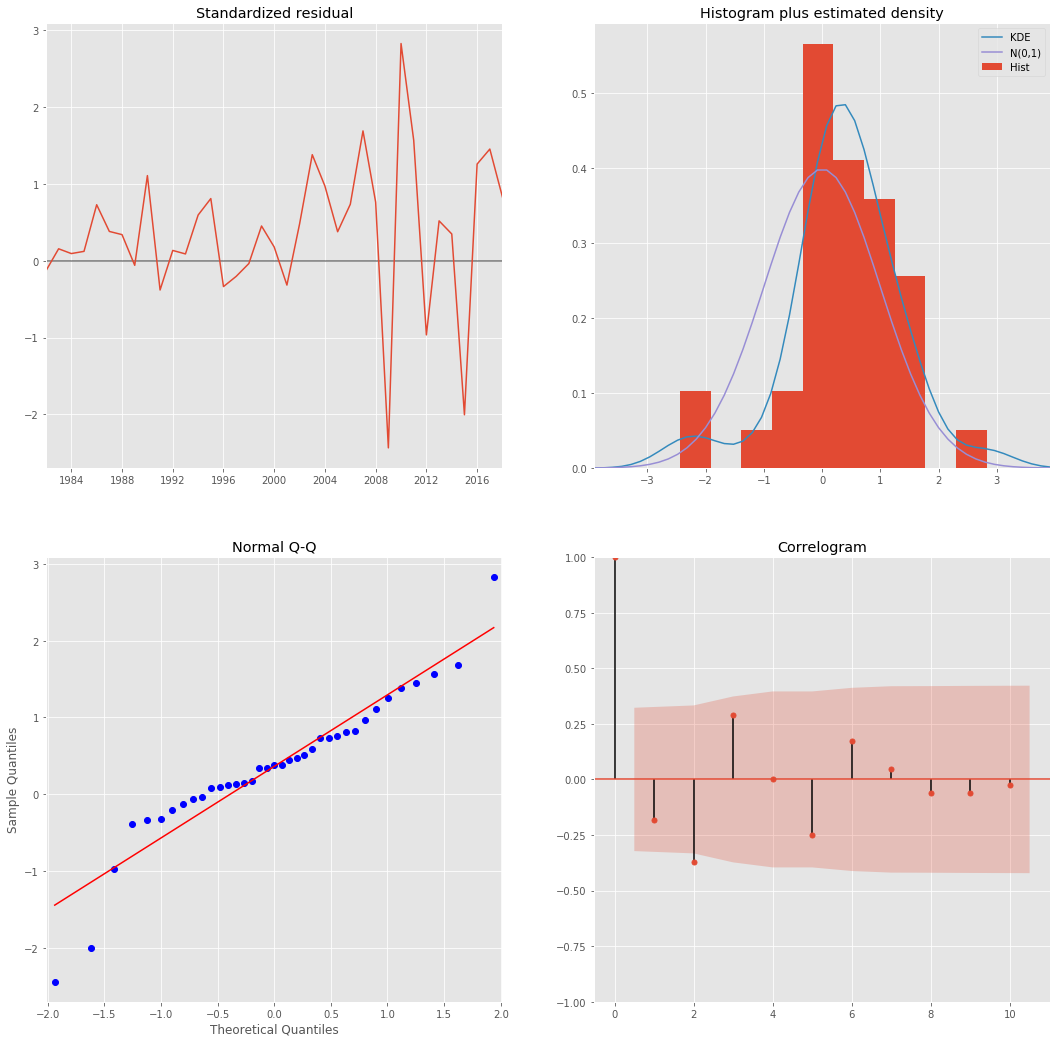

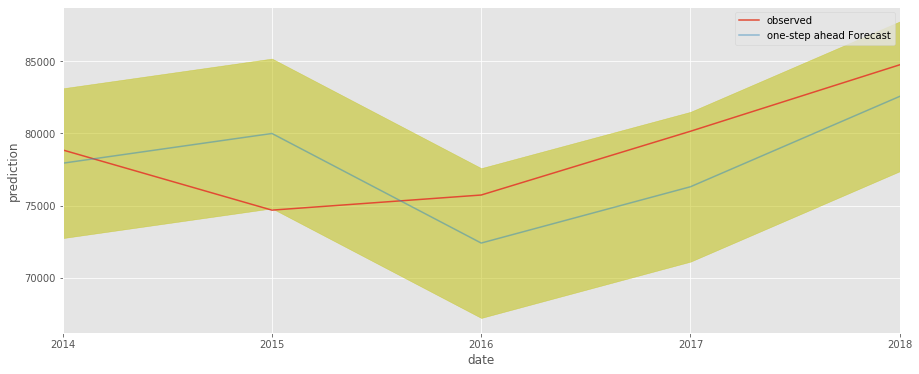

The Mean Squared Error is: 11897812.58


In [120]:
analyse_series(world_gdp_train, 1, 1, 0, 2014)